# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [4]:
%pip install pillow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [229]:
import numpy as np
import os
import imageio
from PIL import Image
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [230]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [231]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())
# batch_size = #experiment with the batch size

train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 20

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [232]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # img_idx = #create a list of image numbers you want to use for a particular video
    img_idx = [item -1  for item in range(1,31) if item % 2 == 0]
    while True:
        t = np.random.permutation(folder_list)
        # num_batches = # calculate the number of batches
        num_batches = len(folder_list) // batch_size # 663/3 = 221 batches
        for batch in range(num_batches): # we iterate over the number of batches
            # batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_data = np.zeros((batch_size,len(img_idx),100,100,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    # image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = image.resize((100,100))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # batch_data[folder,idx,:,:,0] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,1] = #normalise and feed in the image
                    # batch_data[folder,idx,:,:,2] = #normalise and feed in the image
                    r, g, b = image.split()
                    batch_data[folder,idx,:,:,0] = np.array(r)/255
                    batch_data[folder,idx,:,:,1] = np.array(g)/255
                    batch_data[folder,idx,:,:,2] = np.array(b)/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining_folders = len(folder_list) % batch_size
        if remaining_folders > 0:
            batch_data = np.zeros((remaining_folders, len(img_idx), 100, 100, 3))
            batch_labels = np.zeros((remaining_folders, 5))
            for folder in range(remaining_folders):
                imgs = os.listdir(source_path+'/' + t[folder + (num_batches * batch_size)].strip().split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = Image.open(source_path + '/' + t[folder + (num_batches * batch_size)].strip().split(';')[0] + '/' + imgs[item])
                    image = image.resize((100, 100))
                    r, g, b = image.split()
                    batch_data[folder,idx,:,:,0] = np.array(r)/255
                    batch_data[folder,idx,:,:,1] = np.array(g)/255
                    batch_data[folder,idx,:,:,2] = np.array(b)/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [233]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [240]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
# from keras.layers.convolutional import Conv3D, MaxPooling3D
# from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from keras import optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

#write your model here
model = Sequential()
model.add(Conv3D(32, (3,3,3), activation='relu', input_shape = (15, 100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPooling3D((3,3,3)))

model.add(Conv3D(64, (3,3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2,2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [241]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_43 (Conv3D)              │ (None, 13, 98, 98, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 13, 98, 98, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_42 (MaxPooling3D) │ (None, 4, 32, 32, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_44 (Conv3D)              │ (None, 2, 30, 30, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 2, 30, 30, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_43 (MaxPooling3D) │ (None, 1, 15, 15, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,902,341 (7.26 MB)

 Trainable params: 1,902,149 (7.26 MB)

 Non-trainable params: 192 (768.00 B)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [242]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [243]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

# LR = # write the REducelronplateau code here
LR = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode: 1 = print messages when learning rate changes
    mode='auto',         # 'auto', 'min', or 'max'. 'min' looks for a decrease in monitored metric.
    min_delta=1e-4,      # Minimum change in monitored value to qualify as an improvement
    cooldown=0,          # Number of epochs to wait after a learning rate reduction before resuming normal operation
    min_lr=1e-6          # Lower bound on the learning rate
)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [244]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [245]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 20
Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.2944 - loss: 4.5586Source path =  ./Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2025-01-0121_58_47.014757/model-00001-3.43809-0.34540-5.75259-0.24000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - categorical_accuracy: 0.2958 - loss: 4.5266 - val_categorical_accuracy: 0.2400 - val_loss: 5.7526 - learning_rate: 0.0010
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - categorical_accuracy: 0.4843 - loss: 1.6155
Epoch 2: saving model to model_init_2025-01-0121_58_47.014757/model-00002-1.55554-0.48265-2.93685-0.24000.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - categorical_accuracy: 0.4843 - loss: 1.6138 - val_categorical_accuracy: 0.2400 - val_loss: 2.9368 - learning_rate: 0.0010
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - categorical_accuracy: 0.5235 - loss: 1.1948
Epoch 3: saving model to model_init_2025-01-0121_58_47.01

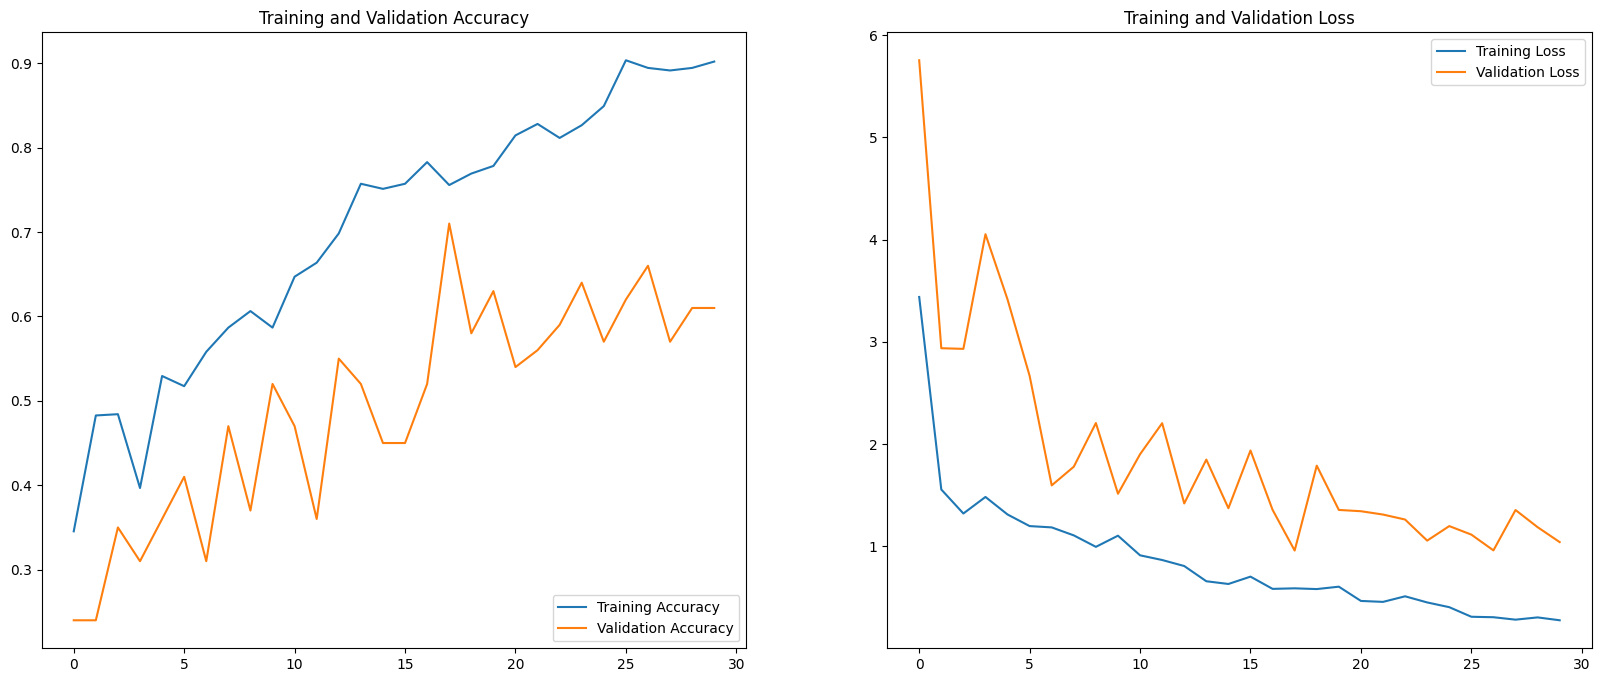

In [246]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Write up

In [ ]:
Model Architecture:

Input Preprocessing:
- I rescaled the images to normalize pixel values to the range [0, 1].

Feature Extraction:
- I used two convolutional layers with ReLU activation, followed by max-pooling and dropout to prevent overfitting.

Classification:
- The extracted features are flattened and passed through a batch-normalized dense layer for better representation.
- The final predictions are made using a softmax activation function across 5 classes.

Key Features:
- Dropout Regularization: I included dropout layers to mitigate overfitting during training.
- Batch Normalization: This helped stabilize training and improve convergence.
- Categorical Classification: The model predicts one of 5 hand gestures.

Accuracy Results:
- 83% for train and 71% for validation
